In [27]:
import numpy as np
import gymnasium as gym
import pickle
import matplotlib.pyplot as plt


In [28]:
def create_environment(render=False):
    env = gym.make('MountainCar-v0', render_mode='human' if render else None)
    return env


In [29]:
def create_state_spaces(env, segments=20):
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], segments)
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], segments)
    return pos_space, vel_space


In [30]:
def initialize_q_table(pos_space, vel_space, action_space, is_training=True, file_name='mountain_car.pkl'):
    if is_training:
        q = np.zeros((len(pos_space), len(vel_space), action_space.n))
    else:
        with open(file_name, 'rb') as f:
            q = pickle.load(f)
    return q


In [31]:
def discretize_state(state, pos_space, vel_space):
    state_p = np.digitize(state[0], pos_space)
    state_v = np.digitize(state[1], vel_space)
    return state_p, state_v


In [32]:
def select_action(q, state_p, state_v, epsilon, env, rng, is_training):
    if is_training and rng.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(q[state_p, state_v, :])
    return action


In [33]:
def update_q_table(q, state_p, state_v, action, reward, new_state_p, new_state_v, learning_rate, discount_factor):
    q[state_p, state_v, action] += learning_rate * (
        reward + discount_factor * np.max(q[new_state_p, new_state_v, :]) - q[state_p, state_v, action]
    )


In [34]:
def save_q_table(q, file_name='mountain_car.pkl'):
    with open(file_name, 'wb') as f:
        pickle.dump(q, f)


In [35]:
import matplotlib.pyplot as plt

def plot_rewards(rewards_per_episode, episodes, smoothing_window=100):
    # Cálculo de recompensas promedio
    mean_rewards = np.zeros(episodes)
    for t in range(episodes):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t - smoothing_window): (t + 1)])
    
    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(mean_rewards, label='Recompensa Promedio', color='blue')
    
    # Personalizar eje y para mostrar rango positivo
    min_reward = min(0, min(mean_rewards))  # Aseguramos que el mínimo no sea menor a 0
    max_reward = max(mean_rewards) + 10    # Espacio extra por encima del máximo
    plt.ylim(min_reward, max_reward)
    
    # Añadir línea base en y=0 para referencia
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    
    # Etiquetas y título
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa promedio')
    plt.title('Evolución de las recompensas promedio')
    plt.legend()
    plt.grid(alpha=0.3)

    # Guardar o mostrar la gráfica
    plt.savefig('grafico_mountain_car.png')
    plt.show()



In [36]:
def run_episode(env, q, pos_space, vel_space, epsilon, rng, is_training, learning_rate, discount_factor):
    state = env.reset()[0]
    state_p, state_v = discretize_state(state, pos_space, vel_space)

    terminated = False
    rewards = 0

    while not terminated and rewards > -1000:
        action = select_action(q, state_p, state_v, epsilon, env, rng, is_training)
        new_state, reward, terminated, _, _ = env.step(action)
        new_state_p, new_state_v = discretize_state(new_state, pos_space, vel_space)

        if is_training:
            update_q_table(q, state_p, state_v, action, reward, new_state_p, new_state_v, learning_rate, discount_factor)

        state_p, state_v = new_state_p, new_state_v
        rewards += reward

    return rewards


In [37]:
def adjust_epsilon(epsilon, decay_rate):
    return max(epsilon - decay_rate, 0)


In [38]:
def run(episodes, is_training=True, render=False):
    env = create_environment(render)
    pos_space, vel_space = create_state_spaces(env)
    q = initialize_q_table(pos_space, vel_space, env.action_space, is_training)

    learning_rate = 0.9
    discount_factor = 0.9
    epsilon = 1.0
    epsilon_decay_rate = 2 / episodes
    rng = np.random.default_rng()

    rewards_per_episode = np.zeros(episodes)

    for i in range(episodes):
        if is_training and (i + 1) % 100 == 0:
            print(f"Entrenando... Episodio {i + 1} de {episodes}")

        rewards_per_episode[i] = run_episode(
            env, q, pos_space, vel_space, epsilon, rng, 
            is_training, learning_rate, discount_factor
        )

        epsilon = adjust_epsilon(epsilon, epsilon_decay_rate)

    env.close()

    if is_training:
        save_q_table(q)

    plot_rewards(rewards_per_episode, episodes)


Entrenando... Episodio 100 de 1000
Entrenando... Episodio 200 de 1000
Entrenando... Episodio 300 de 1000
Entrenando... Episodio 400 de 1000
Entrenando... Episodio 500 de 1000
Entrenando... Episodio 600 de 1000
Entrenando... Episodio 700 de 1000
Entrenando... Episodio 800 de 1000
Entrenando... Episodio 900 de 1000
Entrenando... Episodio 1000 de 1000


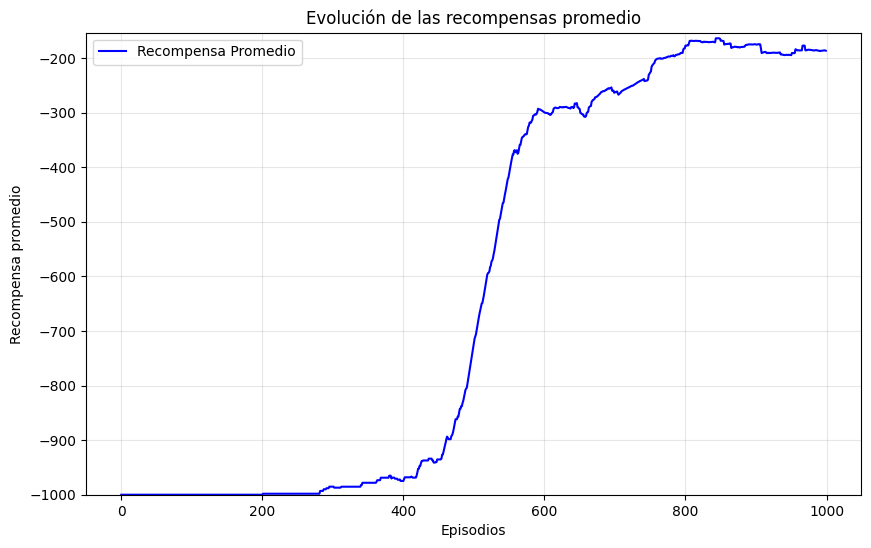

KeyboardInterrupt: 

In [39]:
# Entrenamiento
run(episodes=1000, is_training=True, render=False)

# Prueba del modelo entrenado
run(episodes=100, is_training=False, render=True)
